# PyDelfi

This module gets cosmological constraints from simulations of the CMB Cls using pydelfi. This serves to get an estimate of the sampling error, that we can then compare to MultiSWAG's

In [1]:
import numpy as np
import camb
import os, sys
import matplotlib.pyplot as plt
import getdist
import random
import emcee as mc
from getdist import plots, MCSamples
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import tensorflow as tf
import getdist.plots
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior

sys.path.append("../cosmoswag") 
from cmb_simulator import *

#### Read the CL simulations

In [7]:
cls = np.load('../cosmoswag/data/cmb_sims/cls.npy')
params = np.load('../cosmoswag/data/cmb_sims/params.npy')

theta_norm = normalize_params(params)
_, binned_cls = bin_cls(cls, 250)

#### Use MOPED to compress the data

In [ ]:
theta_fiducial = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
theta0 = unnormalize_params(theta_fiducial)
cl_fiducial = (H0=theta0[0], ombh2=theta0[1], omch2=theta0[2],logA=theta0[3],ns=theta0[4])
Cinv = 1/cl_fiducial

# Define compression as score-MLE of a Wishart likelihood
nl = len(cls_binned[0]) #  Making this up

# Calculate derivatives of the expected power spectrum
step = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = compute_derivatives(theta_fiducial, step)

Compressor = score.Gaussian(nl, theta_fiducial, cl_fiducial, Cinv=cl_fiducial**-1*np.identity(nl), dmudt=dCdt)
Compressor.compute_fisher()

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

Finv = Compressor.Finv
compressed_data = compressor(binned_cls[-1], compressor_args)

compressed_sims = np.zeros_like(y_norm)
for i in range(len(theta_norm[:,0])):
    compressed_sims[i] = compressor(binned_cls[i], compressor_args)

#### Prepare pyDelfi

In [ ]:
n_data = cls_binned.shape[1]
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=4, act_fun=tf.tanh, index=0),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=1),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=7, n_hidden=[50,50], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=10, n_hidden=[50,50], activations=[tf.tanh, tf.tanh], index=3)
]

In [ ]:
observation = compressed_data

lower = np.zeros(5)
upper = np.ones(5)
prior = priors.Uniform(lower, upper)

DelfiEnsemble = delfi.Delfi(observation, prior, NDEs,
                            param_limits = [lower, upper],
                            param_names = ['p1', 'p2', 'p3', 'p4', 'p5'],
                            Finv = Finv,
                            theta_fiducial = theta_fiducial,
                            input_normalization="fisher"
                            #results_dir = 'temp/'
                           )

#DelfiEnsemble.fisher_pretraining()

#### Run the density estimation

In [ ]:
DelfiEnsemble.load_simulations(compressed_sims[:-1000],
                               theta_norm[:-1000])

DelfiEnsemble.train_ndes()

#### Use PolyChord to get posterior distributions

In [ ]:
def likelihood(theta):
    #logL = DelfiEnsemble.log_likelihood_individual(0,theta,cls_binned[-1])
    logL = DelfiEnsemble.log_likelihood_stacked(theta,compressed_data[-1])
    return np.float64(logL), (theta*(maxs-mins)+mins).tolist() 

def prior(hypercube):
    """ Uniform prior from [-1,1]^D. """
    return UniformPrior(0, 1)(hypercube)

def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

nDims = 5
nDerived = 5
    
settings = PolyChordSettings(nDims, nDerived)
settings.base_dir = '../cosmoswag/data/chains/'
settings.file_root = 'pydelfi'
#settings.nlive = 200
settings.do_clustering = True
settings.read_resume = False

output = pypolychord.run_polychord(likelihood, nDims, nDerived, settings, prior, dumper)

#### Plot the posterior distribution using GetDist

In [5]:
#from getdist.mcsamples import loadMCSamples

#posterior = loadMCSamples('../cosmoswag/data/chains/pydelfi')

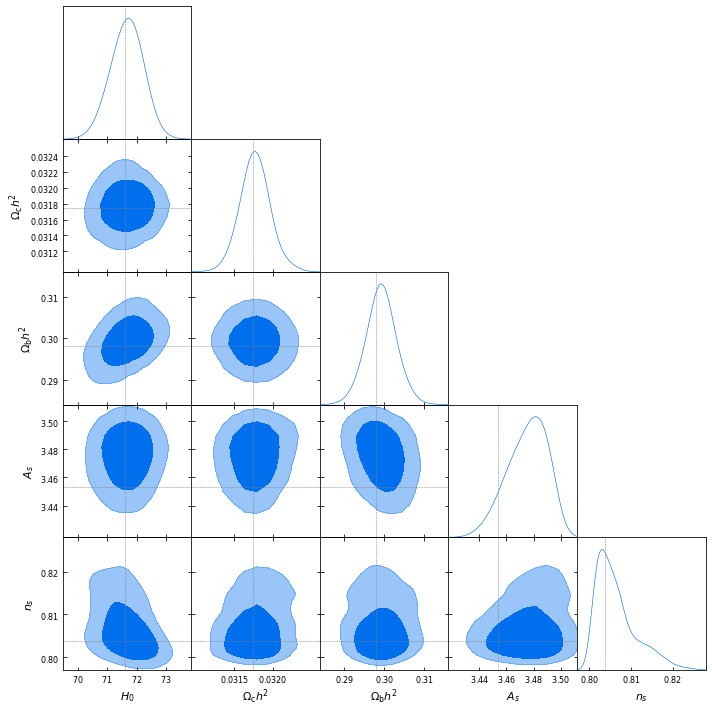

In [8]:
paramnames = [('p%i' % i, r'\theta_%i' % i) for i in range(5)]
paramnames += [("H0", "H_0"), 
               ("omch2",  "\Omega_\mathrm{c} h^2"), 
               ("ombh2",  "\Omega_\mathrm{b} h^2"), 
               ("As", "A_s"), 
               ("ns", "n_s")
              ]
output.make_paramnames_files(paramnames)

posterior = output.posterior
g = getdist.plots.getSubplotPlotter()
g.triangle_plot(posterior, ["H0", "omch2",  "ombh2", "As", "ns"], filled=True,
                              markers={'H0':params[-1,0],
                                       'omch2':params[-1,1],
                                       'ombh2':params[-1,2],
                                       'As':params[-1,3],
                                       'ns':params[-1,4]}
               )